# Image Pyramids and Reconstruction

## Overview
Choose an image that has interesting variety of textures (from Flickr or your own images). The images should be atleast 640X480 pixels and converted to grayscale. In each level, the resolution reduces by a factor of 2. Here is an [example](https://drive.google.com/uc?id=17Y287EA-GJ2z0wtm_M7StIWsXyFeHvrz).

In [ ]:
# Import necessary packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
# Helper Functions

import os

def vis_hybrid_image(hybrid_image):
  scales = 5
  scale_factor = 0.5
  padding = 5
  original_height = hybrid_image.shape[0]
  num_colors = hybrid_image.shape[2] # counting how many color channels the input has
  output = hybrid_image
  cur_image = hybrid_image

  for i in range(2, scales):
      # add padding
      output = np.concatenate((output, np.ones((original_height, padding, num_colors), dtype=int)), axis=1)      
      # dowsample image;
      width = int(cur_image.shape[1] * scale_factor)
      height = int(cur_image.shape[0] * scale_factor)
      dim = (width, height)
      cur_image = cv2.resize(cur_image, dim, interpolation = cv2.INTER_LINEAR)
      # pad the top and append to the output
      tmp = np.concatenate((np.ones((original_height-cur_image.shape[0], cur_image.shape[1], num_colors))*255, cur_image), axis=0)
      output = np.concatenate((output, tmp), axis=1)
  
  output = (output).astype(np.uint8)
  return output

def read_image(image_path):
  # YOUR CODE HERE
  image = cv2.imread(image_path)
  return image

def gaussian_2D_filter(size, cutoff_frequency):
  # YOUR CODE HERE
  ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
  gauss = np.exp(-0.5 * np.square(ax) / np.square(cutoff_frequency))
  filter = np.outer(gauss, gauss)
  return filter / np.sum(filter)

def imgfilter(image, filter):
  # YOUR CODE HERE
  # filtered_img = cv2.sepFilter2D(image,-1,filter,filter)
  filtered_img = cv2.filter2D(image, -1, filter)
  return filtered_img

def log_mag_FFT(image):
  img = cv2.cvtColor(np.uint8(image), cv2.COLOR_BGR2GRAY)
  # output = np.log(np.abs(np.fft.fftshift(np.fft.fft2(image))))
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)
  output = 20*np.log(np.abs(fshift))
  return normalize_img(output, 1.0, 0.0)

def normalize_img(img, max, min):
  max_val = np.max(img)
  min_val = np.min(img)
  img = ((img - min_val)/(max_val-min_val))*max + min
  return img

def matplotlib_conversion(img):
  img = np.uint8(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
!gdown 1nWpXMsMdqkCDmAdpTJSwAxqFJmBdV-_c

Downloading...
From: https://drive.google.com/uc?id=1nWpXMsMdqkCDmAdpTJSwAxqFJmBdV-_c
To: /content/turtle.jpg
100% 1.53M/1.53M [00:00<00:00, 167MB/s]


## Code

In [ ]:
from matplotlib.scale import scale_factory
# Populate Helper Functions:

def createGaussianPyramid(img, num_layers, scale_factor, filter):
  '''Given an image and the number of layers necessary for the pyramid, it creates a list of downsized gaussian images'''
  G = num_layers*[0]

  for i in range(len(G)):
    if i == 0:
      G[i] = np.double(img)
      continue
    G[i] = imgfilter(G[i-1], filter=filter)
    G[i] = cv2.resize(G[i], (int(G[i].shape[1]*scale_factor), int(G[i].shape[0]*scale_factor)), interpolation = cv2.INTER_NEAREST)
  
  return G

def createLaplacianPyramid(G, filter):
  L = len(G)*[0]

  for i in range(len(L)):
    upscaled_gaussian = cv2.resize(G[i+1], (G[i].shape[1], G[i].shape[0]), interpolation = cv2.INTER_NEAREST)
    upscaled_gaussian = imgfilter(upscaled_gaussian, filter=filter)
    L[i] = np.double(G[i]) - np.double(upscaled_gaussian)
    if i == len(L)-2:
      L[i+1] = G[i+1]
      break
  
  return L


def pyramidsGL(image, num_levels):
  ''' Creates Gaussian (G) and Laplacian (L) pyramids of level "num_levels" from image im. 
  G and L are list where G[i], L[i] stores the i-th level of Gaussian and Laplacian pyramid, respectively. '''
  # YOUR CODE HERE

  cutoff_frequency = 4
  filter_size = cutoff_frequency*4+1
  scale_factor = 0.5

  filter = gaussian_2D_filter(filter_size, cutoff_frequency)

  G = createGaussianPyramid(image, num_levels, scale_factor, filter)
  L = createLaplacianPyramid(G, filter)

  return G, L

def displayPyramids(G, L):
  '''Role of this function is to display intensity and Fast Fourier Transform (FFT) images of pyramids.
  NOTE: You may re-use your helper function  "log_mag_FFT" to compute this.'''
  # YOUR CODE HERE

  #Intensity pyramids display
  print("\nDisplaying Intensities of L and G\n")
  fig = plt.figure(figsize=(40, 10))
  rows = 2
  columns = 5
  
  for i in range(1,11,1):
    if i <= 5:
      fig.add_subplot(rows, columns, i)
      # showing image
      img = cv2.cvtColor(np.uint8(G[i-1]), cv2.COLOR_BGR2RGB)
      plt.imshow(img)
      plt.axis('off')

    elif i==10:
      fig.add_subplot(rows, columns, i)
      # showing image
      img = cv2.cvtColor(np.uint8(L[i-6]), cv2.COLOR_BGR2RGB)
      plt.imshow(img)
      plt.axis('off')

    else:
      fig.add_subplot(rows, columns, i)
      # showing image
      img = cv2.cvtColor(np.uint8(normalize_img(L[i-6],255,0)), cv2.COLOR_BGR2RGB)
      plt.imshow(img)
      plt.axis('off')

  plt.show()

  #Fourier pyramids display
  print("\nDisplaying Fourier Transforms of L and G\n")
  fig = plt.figure(figsize=(40, 10))
  rows = 2
  columns = 5
  
  for i in range(1,11,1):
    if i <= 5:
      fig.add_subplot(rows, columns, i)
      # showing image
      plt.imshow(log_mag_FFT(G[i-1]))
      plt.axis('off')

    elif i==10:
      fig.add_subplot(rows, columns, i)
      # showing image
      # img = cv2.cvtColor(np.uint8(L[i-6]), cv2.COLOR_BGR2RGB)
      plt.imshow(log_mag_FFT(L[i-6]))
      plt.axis('off')

    else:
      fig.add_subplot(rows, columns, i)
      # showing image
      # img = cv2.cvtColor(np.uint8(normalize_img(L[i-6],255,0)), cv2.COLOR_BGR2RGB)
      plt.imshow(log_mag_FFT(normalize_img(L[i-6],255,0)))
      plt.axis('off')

  plt.show()
  
  pass

def reconstructLaplacianPyramid(L):
  '''Given a Laplacian Pyramid L, reconstruct an image img.'''
  # YOUR CODE HERE
  cutoff_frequency = 4
  filter_size = cutoff_frequency*4+1
  filter = gaussian_2D_filter(filter_size, cutoff_frequency)
  reconstructed = L[-1]

  for i in range(len(L)-1,-1,-1):
    if i == 0:
      break
    cv2_imshow(reconstructed)
    add = L[i-1]
    reconstructed = cv2.resize(reconstructed, (L[i-1].shape[1], L[i-1].shape[0]), interpolation = cv2.INTER_NEAREST)
    reconstructed = imgfilter(reconstructed, filter=filter)
    reconstructed = (np.double(reconstructed) + np.double(add))

  cv2_imshow(reconstructed)
  return reconstructed



Displaying Intensities of L and G



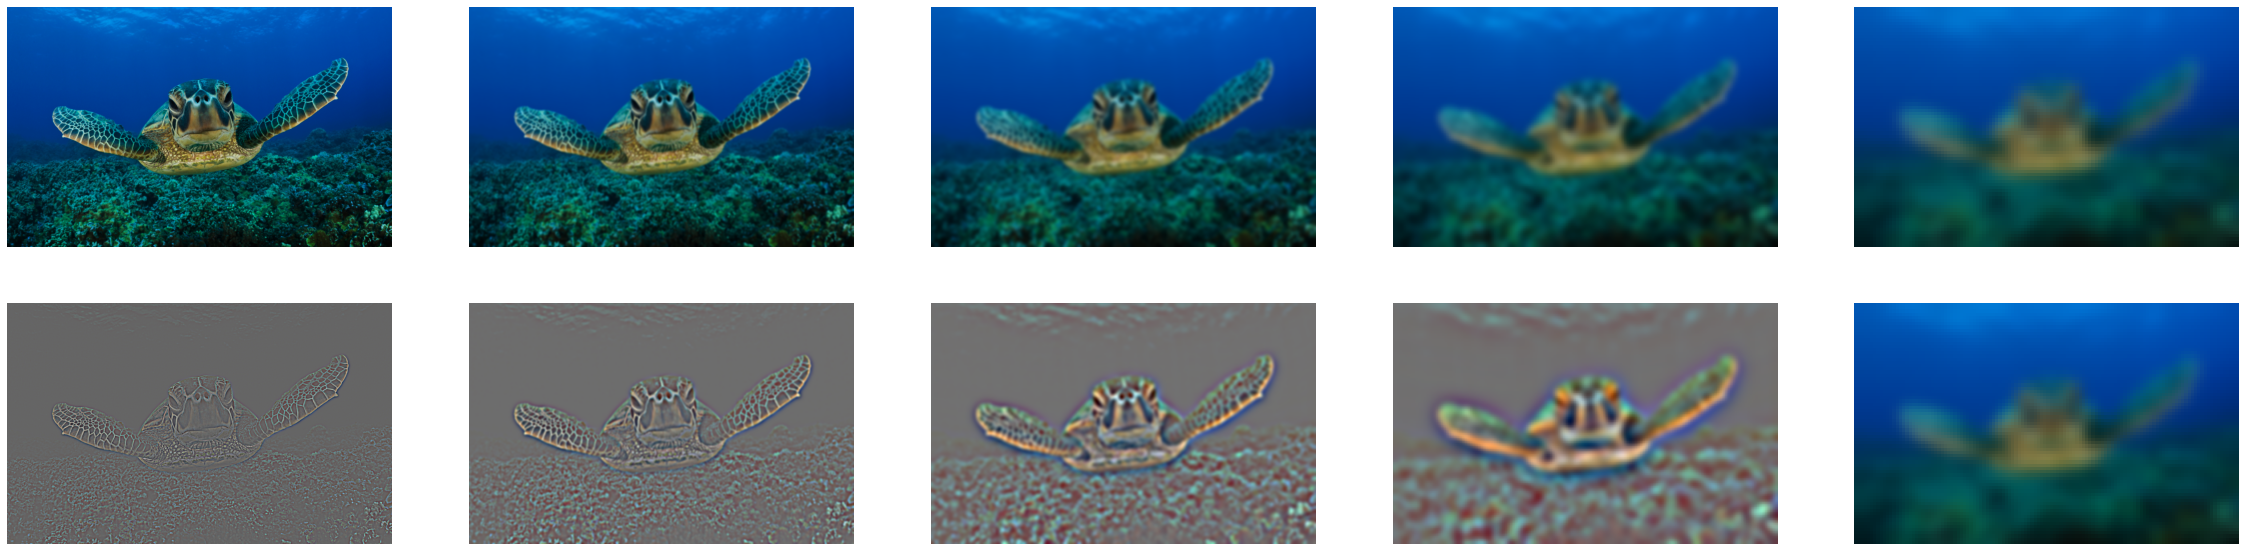


Displaying Fourier Transforms of L and G



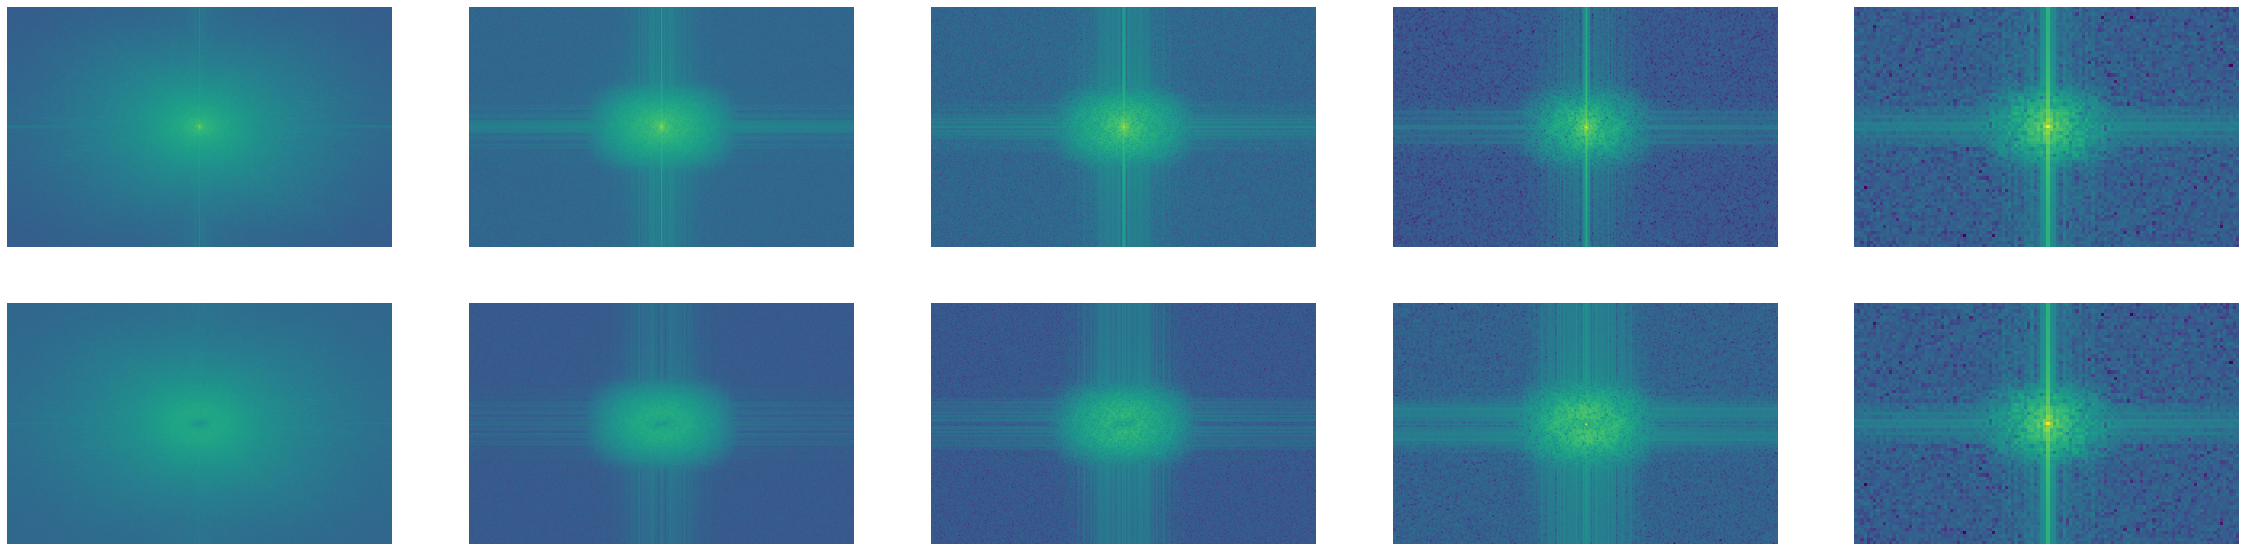

In [ ]:
""" 
Steps:
1. Load an image im.
2. Call function pyramidsGL with image and num_levels = 5
3. Call function displayPyramids with G, L
4. Call function reconstructLaplacianPyramid with the generated L
5. Compute reconstruction error with L2 norm and print the error value.
"""
# YOUR CODE HERE
#1 - Loading Image
im = read_image("/content/turtle.jpg")

#2 - Call function pyramidsGL
G, L = pyramidsGL(im, num_levels = 5)

#3 - Call function displayPyramids
displayPyramids(G,L)


Showing the reconstructed image at each stage



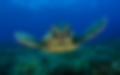

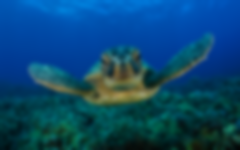

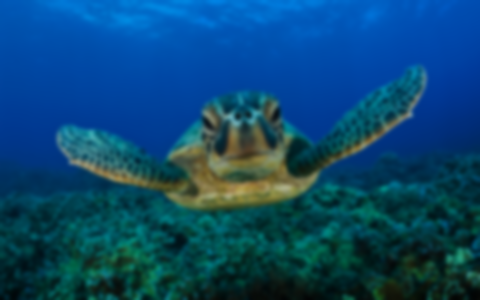

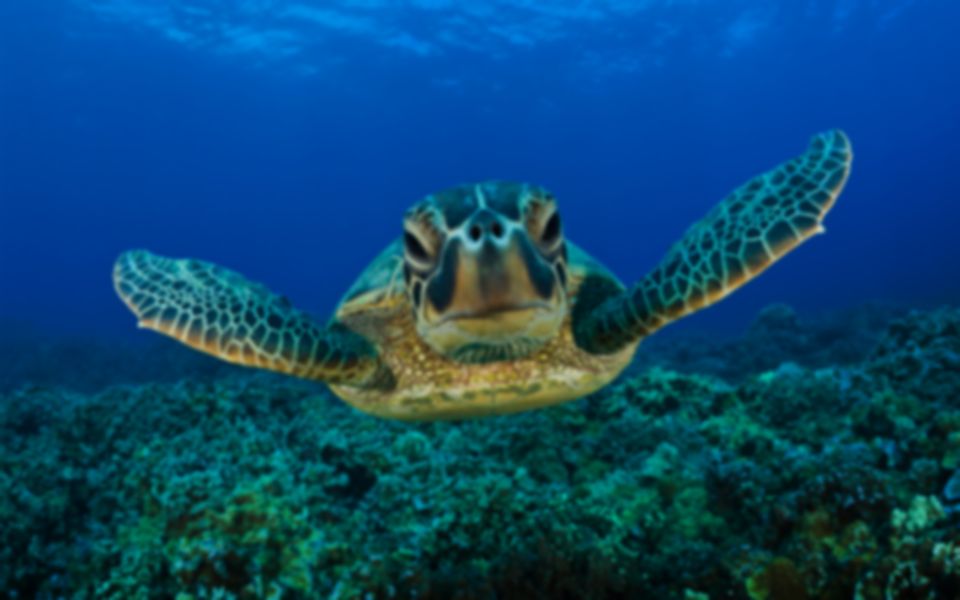

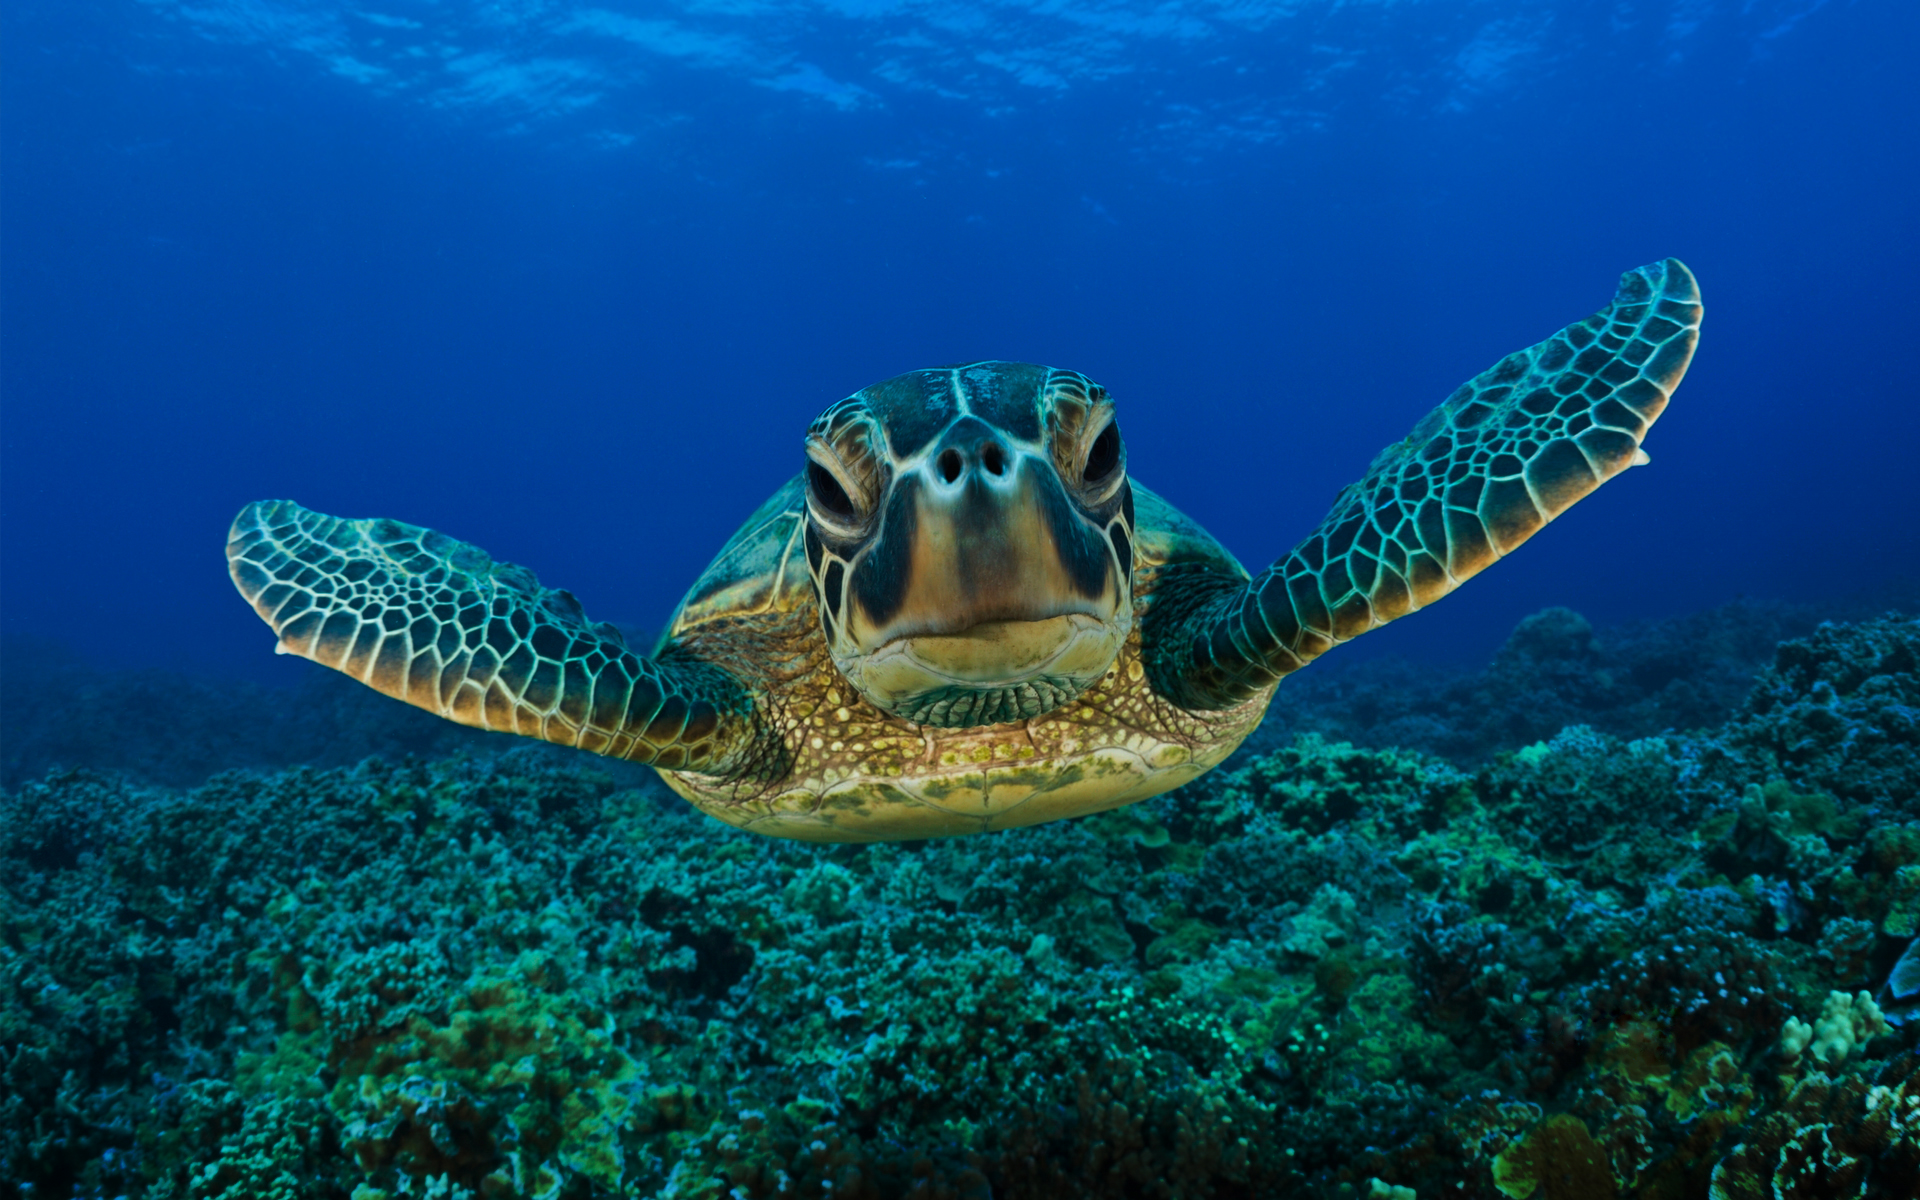


Reconstruction error computed with L2 norm = 2.400575985289343e-11



In [ ]:
#4 - Call function reconstructLaplacianPyramid
print("\nShowing the reconstructed image at each stage\n")
reconstructed = reconstructLaplacianPyramid(L)

#5 - Compute reconstruction error with L2 norm and print the error value
L2_error = np.sqrt(np.sum(np.square(reconstructed - im)))
print("\nReconstruction error computed with L2 norm = " + str(L2_error) +"\n")

Image reconstruction has been shown at every stage and finally the L2 reconstruction error has also been printed which is equal to 2.400575985289343e-11, which is very small. It is not 0 because of the fact that the reconstructed image has double datatype whereas the original image has uint8 datatype. When visualizing double gets recasted into uint8. Hence technically there's no visual difference.